In [2]:
# Query to get data we scraped from
import pandasql as ps
def query():
    # Needs access to title_ratings to run
    q1 = """
    SELECT tconst FROM title_ratings
    JOIN title_basics
    USING(tconst)
    WHERE startYear > 2009
    AND (titleType = 'movie' OR titleType = 'tvMovie')
    """
    qlist = ''
    x = 0
    df = ps.sqldf(q1, locals())
    for i in df['tconst']:
        x+=1
        qlist += str(i+',')

    qlist += '\b'
    with open('qlist.txt', 'w') as f:
        f.write(qlist)
query()

PandaSQLException: (sqlite3.OperationalError) no such table: title_ratings
[SQL: 
    SELECT tconst FROM title_ratings
    JOIN title_basics
    USING(tconst)
    WHERE startYear > 2009
    AND (titleType = 'movie' OR titleType = 'tvMovie')
    ]
(Background on this error at: http://sqlalche.me/e/13/e3q8)

In [3]:
import os
import json
folder_name = 'all_data'
file_list = os.listdir(folder_name)

In [4]:
data = {}
for filename in file_list:
    with open((folder_name +'/'+filename), 'r') as f:
        data.update(json.load(f))
len(data)

31696

In [5]:
import pandas as pd
df = pd.DataFrame.from_dict(data)
df = df.transpose()
df = df.reset_index()
df = df.rename(columns={'index': 'tconst'})


In [7]:
df.to_csv('scraped_data/budget_ratings.csv')

In [5]:
import numpy as np
ratings = ['G', 'PG', 'PG-13', 'R']
df['rating'] = df['rating'].map(lambda x: 'NotRated' if x not in ratings else x)
df['budget'] = df['budget'].map(lambda x: np.NaN if x in[None, 0] else x)
df['gross'] = df['gross'].map(lambda x: np.NaN if x in[None, 0] else x)
df['ww_gross'] = df['ww_gross'].map(lambda x: np.NaN if x in[None, 0] else x)




In [6]:
df

,tconst,budget,gross,ww_gross,rating
0,tt2200832,NaN,NaN,NaN,NotRated
1,tt2200860,NaN,NaN,1924766.0,NotRated
2,tt2200908,NaN,NaN,105367.0,NotRated
3,tt2200926,NaN,NaN,5784.0,NotRated
4,tt2200955,NaN,NaN,NaN,NotRated
...,...,...,...,...,...
55425,tt7225386,NaN,NaN,10323404.0,NotRated
55426,tt7225648,NaN,NaN,168615.0,NotRated
55427,tt7225942,NaN,NaN,NaN,NotRated
55428,tt7227044,75000.0,NaN,NaN,NotRated


In [7]:
#df = df.drop(['rating', 'gross'], axis=1).dropna()


In [8]:
df.reset_index(drop=True, inplace=True)

In [9]:
df

,tconst,budget,gross,ww_gross,rating
0,tt2200832,NaN,NaN,NaN,NotRated
1,tt2200860,NaN,NaN,1924766.0,NotRated
2,tt2200908,NaN,NaN,105367.0,NotRated
3,tt2200926,NaN,NaN,5784.0,NotRated
4,tt2200955,NaN,NaN,NaN,NotRated
...,...,...,...,...,...
55425,tt7225386,NaN,NaN,10323404.0,NotRated
55426,tt7225648,NaN,NaN,168615.0,NotRated
55427,tt7225942,NaN,NaN,NaN,NotRated
55428,tt7227044,75000.0,NaN,NaN,NotRated


,tconst,budget,ww_gross,rating
6,tt2201011,875000.0,8050.0,NotRated
31,tt2202471,10000000.0,1533874.0,NotRated
48,tt2203939,40000000.0,196710396.0,PG-13
67,tt2205401,5000000.0,17534314.0,R
73,tt2205591,100000.0,71737.0,PG
...,...,...,...,...
55380,tt7216256,2500000.0,1151580.0,NotRated
55385,tt7217128,357442.0,1698442.0,NotRated
55398,tt7219324,3200000.0,5720804.0,NotRated
55421,tt7224520,800000.0,76243.0,NotRated


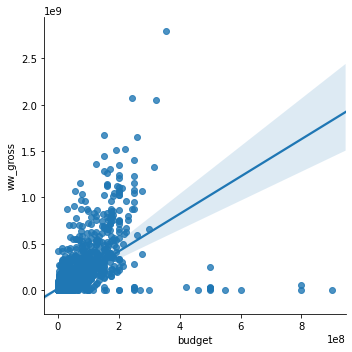

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt
df_drop_gross = df.drop(['gross'], axis=1).dropna()

sns.lmplot(data=df_drop_gross, x='budget', y='ww_gross')
df_drop_gross


,tconst,budget,ww_gross
6,tt2201011,875000.0,8050.0
31,tt2202471,10000000.0,1533874.0
48,tt2203939,40000000.0,196710396.0
67,tt2205401,5000000.0,17534314.0
73,tt2205591,100000.0,71737.0
...,...,...,...
55380,tt7216256,2500000.0,1151580.0
55385,tt7217128,357442.0,1698442.0
55398,tt7219324,3200000.0,5720804.0
55421,tt7224520,800000.0,76243.0


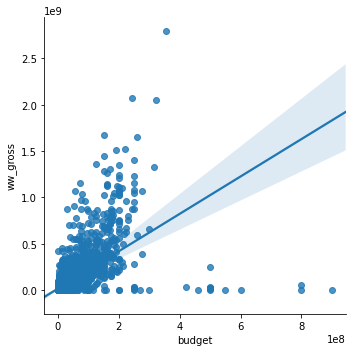

In [16]:
df_drop_rating_gross = df.drop(['rating', 'gross'], axis=1).dropna()
sns.lmplot(data=df_drop_rating_gross, x='budget', y='ww_gross')
df_drop_rating_gross

<AxesSubplot:>

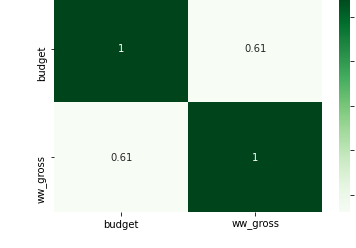

In [17]:
sns.heatmap(df.drop(['rating', 'gross'], axis=1).dropna().corr(), cmap='Greens', annot=True)

<AxesSubplot:>

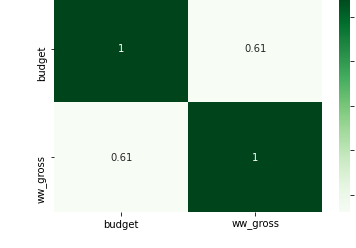

In [18]:
sns.heatmap(df.drop(['gross'], axis=1).dropna().corr(), cmap='Greens', annot=True)

In [51]:
#g = sns.FacetGrid(df_drop_gross, col="rating", height=4, aspect=.4)
#g.map(sns.regplot, "budget", "ww_gross")
df_drop_gross['rating'].value_counts()
#df_drop_gross['budget'].corr(df_drop_gross['rating'])


NotRated    2012
R           1189
PG-13        855
PG           362
TV-MA         69
TV-14         47
G             38
TV-PG         19
TV-G           5
TV-Y7          2
NC-17          1
Name: rating, dtype: int64